In [1]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


## Sky Positions

In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from analysis_tools_cython import *
from tqdm import tqdm

In [3]:
def get_output(file_path):
    """Imports batch_analyse output file as pandas dataframe."""
    with open(file_path) as f:
        lines = f.readlines()
    lc_lists = [word for line in lines for word in line.split()]
    lc_lists = [lc_lists[i:i+10] for i in range(0, len(lc_lists), 10)]
    cols = ['file','signal','signal/noise','time','asym_score','width1','width2','duration','depth','transit_prob']
    df = pd.DataFrame(data=lc_lists,columns=cols)
    df[cols[1:-1]] = df[cols[1:-1]].astype('float32')
    return df

def filter_df(df,min_asym_score=1.0,max_asym_score=2.0,duration=0.5,signal=-5.0):
    """filters df for given parameter range.
    Default settings:
    - `signal/noise` greater than 5.
        - Minimum test statistic is always negative. We flip the sign in plots for convenience.
    - `duration` set to greater than 0.5 days.
    - `asym_score` between 1.00 to 2.0.
    """
    return df[(df.duration >= duration) & (df['signal/noise'] <= signal) & (df['asym_score'] >= min_asym_score) & (df['asym_score'] <= max_asym_score)]


In [4]:
df = get_output('output_log_xrp/output_s6.txt')
filtered_df = filter_df(df)
table = Table.from_pandas(df)

In [9]:
sector = 6
path = f'/storage/astro2/phrdhx/tesslcs/tesslcs_sector_{sector}_104'
clip = 3

In [6]:
box = df[(df['signal/noise'] <= -7.4) & (df['asym_score'] >= 1.30) & (df['transit_prob'] == 'maybeTransit') & (df['asym_score'] <= 1.60) & (df['signal/noise'] >= -12)]
to_import = box['file']

## Finding the sky distribution of the lightcurves
### In our "interesting box region"

In [13]:
box_ra_rad = []
box_dec_rad = []
for i in tqdm(to_import.head(1000)):
    file_paths = glob.glob(os.path.join(path,f'**/{i}'))[0]
    table, store = import_XRPlightcurve(file_paths,sector=sector,clip=clip,drop_bad_points=True) 
    box_tic = store[0]
    chip = store[5]
    ra = store[1] * u.degree
    dec = store[2] * u.degree
    d = SkyCoord(ra=ra, dec=dec, frame='icrs')
    box_ra_rad.append(d.ra.wrap_at(180 * u.deg).radian)
    box_dec_rad.append(d.dec.radian)

100%|██████████| 1000/1000 [01:51<00:00,  9.00it/s]


### The rest of the lightcurves

In [16]:
tic_id = []
ra_tot = []
dec_tot = []
for i in tqdm(df.file.head(1000)):
    file_paths = glob.glob(os.path.join(path,f'**/{i}'))[0]
    table,store = import_XRPlightcurve(file_paths,sector=sector,clip=clip,drop_bad_points=True)
    tic = store[0]
    ra_tot.append(store[1] * u.degree)
    dec_tot.append(store[2] * u.degree)

100%|██████████| 1000/1000 [03:43<00:00,  4.47it/s]


TypeError: only dimensionless scalar quantities can be converted to Python scalars

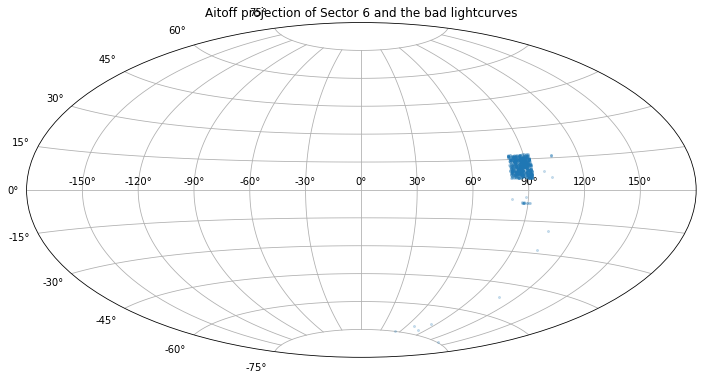

In [17]:
plt.figure(figsize=(12,7))
plt.subplot(111, projection="aitoff")
plt.title("Aitoff projection of Sector 6 and the bad lightcurves")
plt.grid(True)
plt.plot(box_ra_rad, box_dec_rad, 'o', markersize=2, alpha=0.2)
plt.plot(ra_tot,dec_tot,'y', markersize=2, alpha=0.2)
plt.subplots_adjust(top=0.65,bottom=0.0)
plt.savefig('sky positions.png')

---

In [2]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


In [3]:
from astroquery.mast import Observations

In [15]:
obsTable = Observations.query_criteria(provenance='QLP',target_name=270577175)

In [18]:
obsTable[-1]['sequence_number']

34